# RNNLunchJ Better Version

## Pre-Processing

### Download data

In [ ]:
! mkdir TRAIN
! wget https://halldweb.jlab.org/talks/ML_lunch/Sep2019/MLchallenge2_training.csv
! mv MLchallenge2_training.csv TRAIN

! mkdir TEST
! wget https://halldweb.jlab.org/talks/ML_lunch/Sep2019/MLchallenge2_testing_inputs.csv
! mv MLchallenge2_testing_inputs.csv TEST

--2020-11-16 13:55:16--  https://halldweb.jlab.org/talks/ML_lunch/Sep2019/MLchallenge2_training.csv
Resolving halldweb.jlab.org (halldweb.jlab.org)... 129.57.64.128
Connecting to halldweb.jlab.org (halldweb.jlab.org)|129.57.64.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 285951722 (273M) [text/csv]
Saving to: ‘MLchallenge2_training.csv’

MLchallenge2_traini 100%[===================>] 272.70M  39.1MB/s    in 7.6s    

2020-11-16 13:55:24 (36.1 MB/s) - ‘MLchallenge2_training.csv’ saved [285951722/285951722]

--2020-11-16 13:55:24--  https://halldweb.jlab.org/talks/ML_lunch/Sep2019/MLchallenge2_testing_inputs.csv
Resolving halldweb.jlab.org (halldweb.jlab.org)... 129.57.64.128
Connecting to halldweb.jlab.org (halldweb.jlab.org)|129.57.64.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 173137112 (165M) [text/csv]
Saving to: ‘MLchallenge2_testing_inputs.csv’

MLchallenge2_testin 100%[===================>] 165.12M  38.5MB/s    in

### Do Basic Imports

In [ ]:
import numpy as np
from tensorflow import keras
import pandas
from matplotlib import pyplot as plt
from math import isnan
from scipy.stats import norm

### Read training data

In [ ]:
train_csv = pandas.read_csv("TRAIN/MLchallenge2_training.csv")

### Read testing data

In [ ]:
the_max = 0
with open("TEST/MLchallenge2_testing_inputs.csv","r") as mfile:
  lines = mfile.readlines()
  for l in lines:
    data = len(l.split(','))
    the_max = max(the_max,data)
column_names = [i for i in range(0, the_max)]
val_csv = pandas.read_csv("TEST/MLchallenge2_testing_inputs.csv", header=None, names=column_names)
val_csv = val_csv[:20000]

train_x = np.array(train_csv)
val_data = val_csv.values.tolist()
# val_data = np.array(val_csv)
print(train_x.shape)
print(train_csv.keys()[:20])
print(val_csv.keys())
print(val_data[0])


(194601, 150)
Index(['x', 'y', 'z', 'px', 'py', 'pz', 'x1', 'y1', 'z1', 'px1', 'py1', 'pz1',
       'x2', 'y2', 'z2', 'px2', 'py2', 'pz2', 'x3', 'y3'],
      dtype='object')
Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            129, 130, 131, 132, 133, 134, 135, 136, 137, 138],
           dtype='int64', length=139)
[4.24695, -4.43401, 65.0, 0.10800799999999999, 0.139515, 1.9407, 11.63, 2.435, 176.94400000000002, 0.146779, 0.0969276, 1.92955, 11.7922, 2.54127, 179.06900000000002, 0.147668, 0.0961406, 1.9295099999999998, 11.9553, 2.64665, 181.195, 0.148254, 0.0952322, 1.9294900000000001, 12.1188, 2.7509099999999997, 183.32, 0.148627, 0.0942079, 1.9294900000000001, 12.2826, 2.85433, 185.445, 0.149117, 0.0933778, 1.9294799999999999, 12.4474, 2.95667, 187.571, 0.149841, 0.092512, 1.92945, 16.3289, 4.9551099999999995, 235.514, 0.162475, 0.0675623, 1.9293200000000001, 16.5082, 5.02894, 237.639, 0.162772, 0.0667449, 1.9293099999999999, 16.6876, 5.10192, 239.

### Parse Data into for RNN

In [ ]:
def parser(data, thisBool):
  data = data[:10]
  # print(data.shape)
  step = 6
  inputs = 6
  outputs = 6

  batch_x = []
  batch_y = []

  for i in range(len(data)):
    index = 0 
    full_set_x = []
    full_set_y = []
    while index+inputs+outputs < len(data[i]):
      mid = index + inputs
      one_set_x = data[i][index:mid] # + data[i,mid+3] # later fix to get z value
      one_set_y = data[i][mid:mid+outputs]
      flag = False
      for x in one_set_x:
        if isnan(x):
          flag = True
      for y in one_set_y:
        if isnan(y):
          flag = True
      if flag:
        break
      full_set_x.append(one_set_x)
      full_set_y.append(one_set_y)
      index += step
    batch_x.append(full_set_x)
    batch_y.append(full_set_y)

  if thisBool:
    batch_x = np.array(batch_x)
    batch_y = np.array(batch_y)
    print("x",batch_x.shape)
    print("y",batch_y.shape)
  return batch_x,batch_y

x_train,y_train = parser(train_x, True)
# print("train0:",x_train[0].shape)
print("val")
val_x, val_y = parser(val_data, False)
for set_ in range(len(val_x)):
  val_x[set_] = np.array(val_x[set_])
for set_ in range(len(val_y)):
  val_y[set_] = np.array(val_y[set_])

# val_x = np.array(val_x)



x (10, 23, 6)
y (10, 23, 6)
val


### with next z too

In [ ]:
def parser(data, thisBool):
  data = data[0:10]
  # print(data.shape)
  step = 6
  inputs = 6
  outputs = 6
  z_loc = 2

  batch_x = []
  batch_y = []

  for i in range(len(data)):
    index = 0 
    full_set_x = []
    full_set_y = []
    while index+inputs+outputs < len(data[i]):
      mid = index + inputs
      one_set_x = np.append(data[i][index:mid],data[i][mid+z_loc])
      one_set_y = data[i][mid:mid+outputs]
      flag = False
      for x in one_set_x:
        if isnan(x):
          flag = True
      for y in one_set_y:
        if isnan(y):
          flag = True
      if flag:
        break
      full_set_x.append(one_set_x)
      full_set_y.append(one_set_y)
      index += step
    batch_x.append(full_set_x)
    batch_y.append(full_set_y)

  if thisBool:
    batch_x = np.array(batch_x)
    batch_y = np.array(batch_y)
    print("x",batch_x.shape)
    print("y",batch_y.shape)
  return batch_x,batch_y

x_train,y_train = parser(train_x, True)
# print("train0:",x_train[0].shape)
print("val")
val_x, val_y = parser(val_data, False)
for set_ in range(len(val_x)):
  val_x[set_] = np.array(val_x[set_])
for set_ in range(len(val_y)):
  val_y[set_] = np.array(val_y[set_])

# val_x = np.array(val_x)



x (50000, 23, 7)
y (50000, 23, 6)
val


## Build Model

### Different models

In [ ]:
def RNN(inp,x):
  x = keras.layers.LSTM(10,activation="relu", input_shape=inp, return_sequences=True)(x)
  x = keras.layers.TimeDistributed(keras.layers.Dense(6,activation="linear"))(x)
  return x
def RNNOther(inp,x):
  # CuDNN
  x = keras.layers.GRU(256, return_sequences=True)(x)
  x = keras.layers.SimpleRNN(64, activation="linear")(x)
  x = keras.layers.Dense(6,activation="linear")(x)
  return x
def RNNExtra(inp,x):
  x = keras.layers.LSTM(16,activation="linear", name='input_lstm1', return_sequences=True)(x)
  x = keras.layers.LSTM(16,activation="linear", name='lstm2', return_sequences=False)(x)

  # x = keras.layers.LSTM(16,activation="linear", return_sequences=True)(x)
  # x = keras.layers.TimeDistributed(keras.layers.Dense(6,activation="linear"))(x)

  # x = keras.layers.TimeDistributed(keras.layers.Dense(64,activation="linear"))(x)
  x = keras.layers.Dense(64, activation='linear')(x)
  x = keras.layers.Dense(32, activation='linear')(x)
  x = keras.layers.Dense(6, activation='linear')(x)
  return x


def split_it(inp):
  x = keras.layers.Dense(1, activation="linear", name="x_out")(inp)
  y = keras.layers.Dense(1, activation="linear", name="y_out")(inp)
  z = keras.layers.Dense(1, activation="linear", name="z_out")(inp)
  px = keras.layers.Dense(1, activation="linear", name="px_out")(inp)
  py = keras.layers.Dense(1, activation="linear", name="py_out")(inp)
  pz = keras.layers.Dense(1, activation="linear", name="pz_out")(inp)
  return [x,y,z,px,py,pz]



## Divider here to run set faster

### Build model

In [ ]:
inputs = keras.layers.Input((None,6))

from tensorflow.random import set_seed

# np.random.seed(1)
# set_seed(2)

# x = RNN((None,6),inputs)
# out = split_it(x)
# outputs = {
#     "x_out":out[0],
#     "y_out":out[1],
#     "z_out":out[2],
#     "px_out":out[3],
#     "py_out":out[4],
#     "pz_out":out[5]
# }
# model = keras.Model(inputs=inputs, outputs=outputs, name="RNNModelJLab")


#------------------------


# x = RNN((None,7),inputs)
# x = RNNOther((None,6),inputs)
x = RNNExtra((None,6),inputs)
model = keras.Model(inputs=inputs, outputs=x, name="RNNModel")

In [ ]:


optimizer = keras.optimizers.Adam(learning_rate=0.01)
# loss_weights = [1/60.*100,
#                 1/60.*100,
#                 1/400.*100,
#                 1/0.6*100*100,
#                 1/0.6*100*100,
#                 1/4.*100*100]

# loss_weights = [1/(2.1614**2),
#                 1/(2.0778**2),
#                 1/(0.1851**2),
#                 1/(0.1270**2),
#                 1/(0.1204**2),
#                 1/(0.4716**2)]
# loss_weights = np.array(loss_weights)/sum(loss_weights)

model.summary()
# model.compile(optimizer=optimizer, loss="mse", loss_weights=loss_weights, metrics=["mae"])
model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])


Model: "RNNModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_46 (InputLayer)        [(None, None, 6)]         0         
_________________________________________________________________
input_lstm1 (LSTM)           (None, None, 16)          1472      
_________________________________________________________________
lstm2 (LSTM)                 (None, 16)                2112      
_________________________________________________________________
dense_56 (Dense)             (None, 64)                1088      
_________________________________________________________________
dense_57 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_58 (Dense)             (None, 6)                 198       
Total params: 6,950
Trainable params: 6,950
Non-trainable params: 0
________________________________________________________

In [ ]:

def data_generator(x_data,y_data):
  size = len(x_data)
  x_data = np.array(x_data)
  y_data = np.array(y_data)
  while True:
    s = np.arange(size)
    np.random.shuffle(s)
    counter = 0
    x_arr = []
    y_arr = []
    for x, y in zip(x_data[s],y_data[s]):
    # for x, y in zip(x_data,y_data):s
    
      x = np.expand_dims(x,0)
      # y = np.expand_dims(y,0)
      
      # x = tf.ragged.constant(x)
      # y = tf.ragged.constant(y)

      x_arr.append(x)
      y_arr.append(y)
      counter += 1

      if counter == 1:
        counter = 0
        yield x_arr,y_arr
        x_arr = []
        y_arr = []
      
train_gen = data_generator(x_train,y_train)
val_gen = data_generator(val_x,val_y)
x ,y = next(val_gen)
print(len(x), x[0].shape)
print(len(y), y[0].shape)

1 (1, 6, 6)
1 (6, 6)


## Fit Model

### Fit model


In [ ]:
# Current Best

# es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1, patience=5, mode='min', verbose=1, restore_best_weights=True)
# es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, mode='min', verbose=1, restore_best_weights=True)
# H = model.fit(x=train_gen, validation_data=val_gen, validation_steps=100, steps_per_epoch=int(50000/32), epochs=200, verbose=1, callbacks=[es])
# H = model.fit(x=train_gen, validation_data=val_gen, validation_steps=100, steps_per_epoch=10, epochs=200, verbose=1, callbacks=[es])
# es = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.001, patience=100, mode='min', verbose=1, restore_best_weights=True)
# H = model.fit(x=train_gen, batch_size=1, steps_per_epoch=10, epochs=1000, verbose=1, callbacks=[es])
H = model.fit(x=train_gen, batch_size=1, steps_per_epoch=10, epochs=1000, verbose=1)



Epoch 1/1000
10/10 [==============================] - 0s 15ms/step - loss: 71923.2812 - mae: 169.8697
Epoch 2/1000
10/10 [==============================] - 0s 13ms/step - loss: 397945.4062 - mae: 319.7386
Epoch 3/1000
10/10 [==============================] - 0s 14ms/step - loss: 132750.4375 - mae: 148.5476
Epoch 4/1000
10/10 [==============================] - 0s 13ms/step - loss: 14648.9814 - mae: 67.1382
Epoch 5/1000
10/10 [==============================] - 0s 14ms/step - loss: 11285.8965 - mae: 56.5861
Epoch 6/1000
10/10 [==============================] - 0s 13ms/step - loss: 9542.3408 - mae: 55.1040
Epoch 7/1000
10/10 [==============================] - 0s 13ms/step - loss: 9141.6523 - mae: 53.3243
Epoch 8/1000
10/10 [==============================] - 0s 14ms/step - loss: 9025.8809 - mae: 53.3097
Epoch 9/1000
10/10 [==============================] - 0s 13ms/step - loss: 6433.9556 - mae: 47.6956
Epoch 10/1000
10/10 [==============================] - 0s 14ms/step - loss: 5107.2920 - ma

KeyboardInterrupt: ignored

In [ ]:
model = keras.models.load_model('VeryGoodModelFin')


In [ ]:
x = []
y = []
final = []
for i in range(10):
  _x, _y = next(train_gen)
  pred = model.predict(_x, batch_size=1, steps=10)
  final.append(pred-_y)



# print(final)


In [ ]:
final = np.array(final)
final = np.squeeze(final)
print(final.shape)
final = abs(final)
a = np.sum(final, axis=0)
b = np.sum(a, axis=0)
print(b.shape)
print(b)
print(loss_weights)



(10, 23, 6)
(6,)
[4814.95939974 2398.39720714 8068.12521729   17.70396598   21.53213214
  128.22035921]


NameError: ignored

In [ ]:
model.save('VeryGoodModelFin', save_format="h5")


## Graphs

In [ ]:
print(H.history.keys())
print(H.history["loss"])
print(H.history["mae"])
print(H.history["val_loss"])
print(H.history["val_mae"])


dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])
[70.17005157470703, 71.23815155029297, 71.9735107421875, 67.41995239257812, 66.68295288085938, 68.78646087646484]
[4.933138370513916, 4.911922931671143, 4.965084075927734, 4.785682201385498, 4.737977981567383, 4.847721099853516]
[53.51274490356445, 56.183834075927734, 54.979454040527344, 55.8891716003418, 56.63331604003906, 58.3902587890625]
[4.393223285675049, 4.489119052886963, 4.257044315338135, 4.50246000289917, 4.400571823120117, 4.523636817932129]


### Graph loss and mae

dict_keys(['loss', 'mean_absolute_error'])


KeyError: ignored

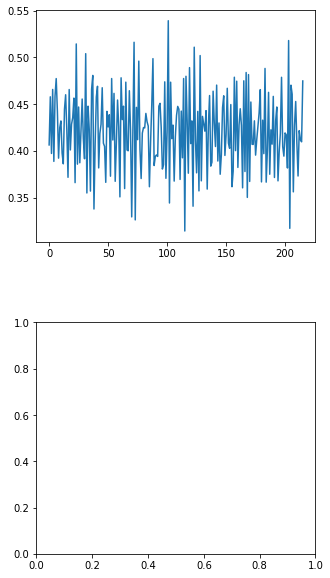

In [ ]:
print(H.history.keys())


lim = 2

try:
  print(H.history["x_out_loss"])
  fig, ax = plt.subplots(1,2,figsize=(10,5))

  # ax[0].plot(H.history["loss"])
  ax[0].plot(H.history["x_out_loss"][lim:])
  ax[0].plot(H.history["y_out_loss"][lim:])
  ax[0].plot(H.history["z_out_loss"][lim:])
  ax[0].plot(H.history["px_out_loss"][lim:])
  ax[0].plot(H.history["py_out_loss"][lim:])
  ax[0].plot(H.history["pz_out_loss"][lim:])
  ax[0].set_title("epoch vs loss")

  ax[1].plot(H.history["x_out_mae"][lim:])
  ax[1].plot(H.history["y_out_mae"][lim:])
  ax[1].plot(H.history["z_out_mae"][lim:])
  ax[1].plot(H.history["px_out_mae"][lim:])
  ax[1].plot(H.history["py_out_mae"][lim:])
  ax[1].plot(H.history["pz_out_mae"][lim:])
  ax[1].set_title("epoch vs mae")
  
except KeyError:
    fig, ax = plt.subplots(2,1,figsize=(5,10))
    fig.subplots_adjust(hspace=0.35)

    ax[0].plot(H.history["loss"][lim:])
    ax[0].plot(H.history["val_loss"][lim:])
    ax[0].set_title("loss vs epoch", fontsize=20)
    ax[0].set_xlabel("epoch", fontsize=15)
    ax[0].set_ylabel("loss", fontsize=15)
    ax[0].legend(["train","val"])
    ax[0].grid(True)


    ax[1].plot(H.history["mae"][lim:])
    ax[1].plot(H.history["val_mae"][lim:])
    ax[1].set_title("mae vs epoch", fontsize=20)
    ax[1].set_xlabel("epoch", fontsize=15)
    ax[1].set_ylabel("mae", fontsize=15)
    ax[1].legend(["train","val"])
    ax[1].grid(True)


### Using generators

(4471, 6)
data 0  |: mu:  -0.6911882056673713 sigma:  3.4527451271026814
data 1  |: mu:  0.38482378520690125 sigma:  4.615765685002956
data 2  |: mu:  -0.45808219438355813 sigma:  5.584060633965038
data 3  |: mu:  0.01706113821561248 sigma:  0.15757937428485017
data 4  |: mu:  0.16176916037479508 sigma:  0.16455794094287263
data 5  |: mu:  -0.12625787695785862 sigma:  1.4165657285228854


Text(0.5, 0, 'true pz')

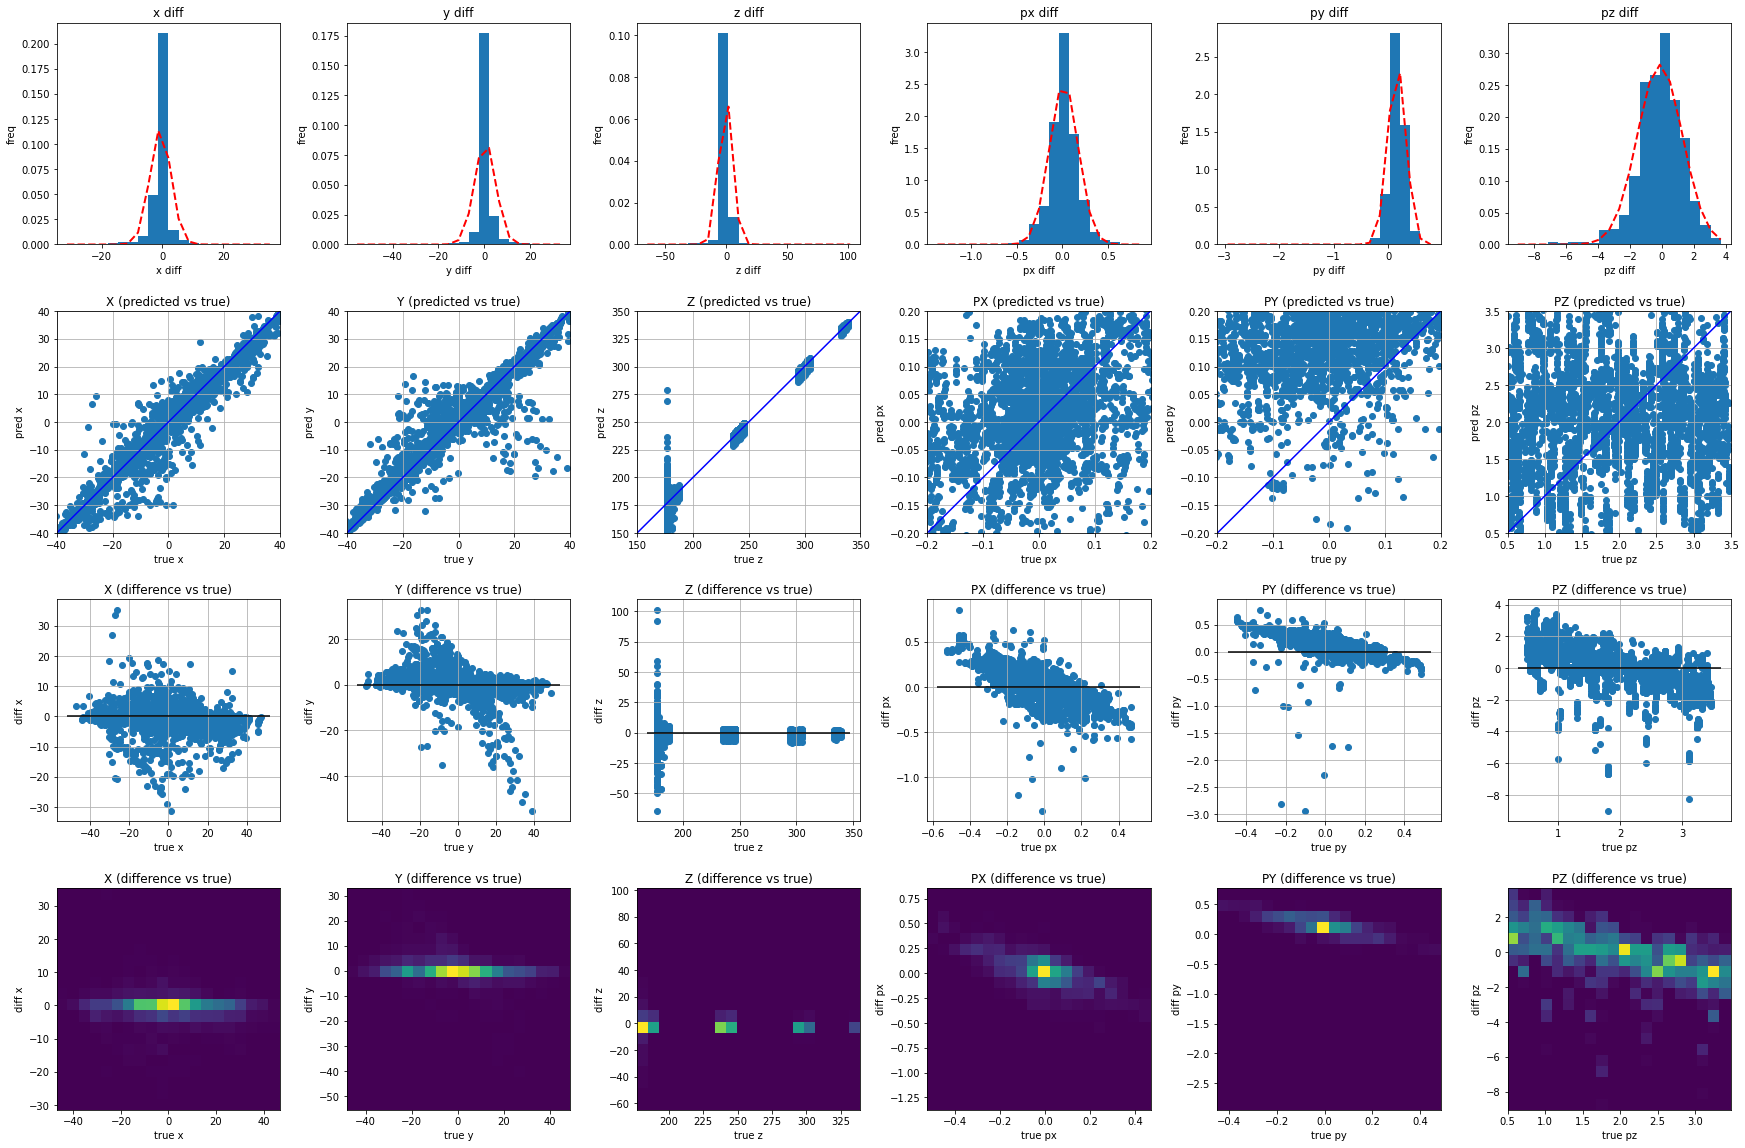

In [ ]:

useStrings = False
numOfSets = 10

batch_size = 32

diff_x = []
true_x = []
betterYArr = []
betterPred = []


# pred = []
# yArr = []
# for i in range(numOfSets):
#   v, y = next(train_gen)
#   for aa in range(1):
#     p = model.predict( v[aa] )
#     p = np.squeeze(p)
#     y_a = np.squeeze(y[aa])
#     yArr.append(y_a)
#     pred.append(p)

# for set_ in range(numOfSets*1):
#   for rr in range(np.ma.size(yArr[set_],0)):
#     diff_x.append(pred[set_][rr] - yArr[set_][rr])
#     true_x.append(yArr[set_][rr])
#     betterYArr.append(yArr[set_][rr])
#     betterPred.append(pred[set_][rr])


if not useStrings:
  pred = []
  yArr = []
  for i in range(numOfSets):
    v, y = next(val_gen)
    for aa in range(batch_size):
      p = model.predict( v[aa] )
      p = np.squeeze(p)
      y_a = np.squeeze(y[aa])
      yArr.append(y_a)
      pred.append(p)

  for set_ in range(numOfSets*batch_size):
    for rr in range(np.ma.size(yArr[set_],0)):
      diff_x.append(pred[set_][rr] - yArr[set_][rr])
      true_x.append(yArr[set_][rr])
      betterYArr.append(yArr[set_][rr])
      betterPred.append(pred[set_][rr])
else:
  pred = []
  yArr = []
  for i in range(numOfSets):
    v, y = next(val_gen)
    p = model.predict( v )
    vals = []
    for a in range(len(p["x_out"][0])):
      vv = []
      vv.append(p["x_out"][0][a])
      vv.append(p["y_out"][0][a])
      vv.append(p["z_out"][0][a])
      vv.append(p["px_out"][0][a])
      vv.append(p["py_out"][0][a])
      vv.append(p["pz_out"][0][a])
      vals.append(vv)
    vals = np.array(vals)
    vals = np.squeeze(vals)
    p = np.squeeze(p)
    y = np.squeeze(y)
    yArr.append(y)
    pred.append(vals)
  for set_ in range(numOfSets):
    for rr in range(np.ma.size(yArr[set_],0)):
      diff_x.append(yArr[set_][rr] - pred[set_][rr])
      true_x.append(yArr[set_][rr])
      betterYArr.append(yArr[set_][rr])
      betterPred.append(pred[set_][rr])




diff_x = np.array(diff_x)
true_x = np.array(true_x)
betterYArr = np.array(betterYArr)
betterPred = np.array(betterPred)
print(diff_x.shape)




fig, axs = plt.subplots(4,6,figsize=(30,20))
fig.subplots_adjust(wspace=0.3, hspace=0.3)

#--------------------------------------
# DIFF 1D HIST
#--------------------------------------



for i in range(6):
  (mu, sigma) = norm.fit(diff_x[:,i])
  print("data" , i ," |: mu: ", mu, "sigma: " , sigma)
  _, bins, _ = axs[0,i].hist(diff_x[:,i], 20, density=True)
  y = norm.pdf(bins, mu, sigma)
  l = axs[0,i].plot(bins, y, 'r--', linewidth=2)

# axs[0,0].set_xlim([-10,10])

axs[0,0].set_title('x diff')
axs[0,0].set_ylabel('freq')
axs[0,0].set_xlabel('x diff')

axs[0,1].set_title('y diff')
axs[0,1].set_ylabel('freq')
axs[0,1].set_xlabel('y diff')

axs[0,2].set_title('z diff')
axs[0,2].set_ylabel('freq')
axs[0,2].set_xlabel('z diff')

axs[0,3].set_title('px diff')
axs[0,3].set_ylabel('freq')
axs[0,3].set_xlabel('px diff')

axs[0,4].set_title('py diff')
axs[0,4].set_ylabel('freq')
axs[0,4].set_xlabel('py diff')

axs[0,5].set_title('pz diff')
axs[0,5].set_ylabel('freq')
axs[0,5].set_xlabel('pz diff')

#--------------------------------------
# PREDICTED VS TRUE
#--------------------------------------
  
for i in range(6):
  axs[1,i].scatter(true_x[:,i],betterPred[:,i])
  axs[1,i].grid(True)

  # xl, xr = axs[1,i].get_xlim()
  # yl, yr = axs[1,i].get_ylim()
  # mmin = min(xr,yr)
  # mmax = max(xl,yl)
  # axs[1,i].plot([mmax,mmin],[mmax,mmin], color='b')

axs[1,0].set_title('X (predicted vs true)')
axs[1,0].set_ylabel('pred x')
axs[1,0].set_xlabel('true x')
axs[1,0].set_xlim([-40,40])
axs[1,0].set_ylim([-40,40])
axs[1,0].plot([-40,40],[-40,40], color='b')

axs[1,1].set_title('Y (predicted vs true)')
axs[1,1].set_ylabel('pred y')
axs[1,1].set_xlabel('true y')
axs[1,1].set_xlim([-40,40])
axs[1,1].set_ylim([-40,40])
axs[1,1].plot([-40,40],[-40,40], color='b')

axs[1,2].set_title('Z (predicted vs true)')
axs[1,2].set_ylabel('pred z')
axs[1,2].set_xlabel('true z')
axs[1,2].set_xlim([150,350])
axs[1,2].set_ylim([150,350])
axs[1,2].plot([150,350],[150,350], color='b')

axs[1,3].set_title('PX (predicted vs true)')
axs[1,3].set_ylabel('pred px')
axs[1,3].set_xlabel('true px')
axs[1,3].set_xlim([-0.2,0.2])
axs[1,3].set_ylim([-0.2,0.2])
axs[1,3].plot([-0.2,0.2],[-0.2,0.2], color='b')

axs[1,4].set_title('PY (predicted vs true)')
axs[1,4].set_ylabel('pred py')
axs[1,4].set_xlabel('true py')
axs[1,4].set_xlim([-0.2,0.2])
axs[1,4].set_ylim([-0.2,0.2])
axs[1,4].plot([-0.2,0.2],[-0.2,0.2], color='b')

axs[1,5].set_title('PZ (predicted vs true)')
axs[1,5].set_ylabel('pred pz')
axs[1,5].set_xlabel('true pz')
axs[1,5].set_xlim([0.5,3.5])
axs[1,5].set_ylim([0.5,3.5])
axs[1,5].plot([0.5,3.5],[0.5,3.5], color='b')

#--------------------------------------
# DIFFERENCE VS TRUE
#--------------------------------------

for i in range(6):
  axs[2,i].scatter(true_x[:,i],diff_x[:,i])
  l, r = axs[2,i].get_xlim()
  axs[2,i].hlines(0, l, r)
  axs[2,i].grid(True)

axs[2,0].set_title('X (difference vs true)')
axs[2,0].set_ylabel('diff x')
axs[2,0].set_xlabel('true x')

axs[2,1].set_title('Y (difference vs true)')
axs[2,1].set_ylabel('diff y')
axs[2,1].set_xlabel('true y')

axs[2,2].set_title('Z (difference vs true)')
axs[2,2].set_ylabel('diff z')
axs[2,2].set_xlabel('true z')

axs[2,3].set_title('PX (difference vs true)')
axs[2,3].set_ylabel('diff px')
axs[2,3].set_xlabel('true px')

axs[2,4].set_title('PY (difference vs true)')
axs[2,4].set_ylabel('diff py')
axs[2,4].set_xlabel('true py')

axs[2,5].set_title('PZ (difference vs true)')
axs[2,5].set_ylabel('diff pz')
axs[2,5].set_xlabel('true pz')

#--------------------------------------
# DIFFERENCE VS TRUE 2D HIST
#--------------------------------------

for i in range(6):
  axs[3,i].hist2d(true_x[:,i],diff_x[:,i],bins=20)


axs[3,0].set_title('X (difference vs true)')
axs[3,0].set_ylabel('diff x')
axs[3,0].set_xlabel('true x')

axs[3,1].set_title('Y (difference vs true)')
axs[3,1].set_ylabel('diff y')
axs[3,1].set_xlabel('true y')

axs[3,2].set_title('Z (difference vs true)')
axs[3,2].set_ylabel('diff z')
axs[3,2].set_xlabel('true z')

axs[3,3].set_title('PX (difference vs true)')
axs[3,3].set_ylabel('diff px')
axs[3,3].set_xlabel('true px')

axs[3,4].set_title('PY (difference vs true)')
axs[3,4].set_ylabel('diff py')
axs[3,4].set_xlabel('true py')

axs[3,5].set_title('PZ (difference vs true)')
axs[3,5].set_ylabel('diff pz')
axs[3,5].set_xlabel('true pz')



### Values withOUT seperated outputs

In [ ]:

diff_x = []
true_x = []
if False:
  pred = []
  for i in range(20):
    v = np.expand_dims(val_x[i],0)
    p = model.predict( v )
    p = np.squeeze(p)
    pred.append(p)

  for x in range(20):
    # for rr in range(len(val_x[x])):
    for rr in range(np.ma.size(val_x[x],1)):
      diff_x.append(val_x[x][rr] - pred[x][0,rr])
      true_x.append(val_x[x][rr])
else:
  pred = model.predict(x_train[:20])

  for x in range(20):
    for rr in range(len(y_train[x])):
      diff_x.append(y_train[x][rr] - pred[x][rr])
      true_x.append(y_train[x][rr])
  # for x in range(20):
  #   for rr in range(len(x_train[x])):
  #     diff_x.append(x_train[x][rr] - pred[x][rr])
  #     true_x.append(x_train[x][rr])




diff_x = np.array(diff_x)
true_x = np.array(true_x)
print(diff_x.shape)




fig, axs = plt.subplots(4,6,figsize=(30,20))

axs[0,0].hist(diff_x[:,0],20,range=[-20,20])
axs[0,0].set_title('x diff')
axs[0,0].set_ylabel('freq')
axs[0,0].set_xlabel('x diff')

axs[0,1].hist(diff_x[:,1],20)
axs[0,1].set_title('y diff')
axs[0,1].set_ylabel('freq')
axs[0,1].set_xlabel('y diff')

axs[0,2].hist(diff_x[:,2],20)
axs[0,2].set_title('z diff')
axs[0,2].set_ylabel('freq')
axs[0,2].set_xlabel('z diff')

axs[0,3].hist(diff_x[:,3],20)
axs[0,3].set_title('px diff')
axs[0,3].set_ylabel('freq')
axs[0,3].set_xlabel('px diff')

axs[0,4].hist(diff_x[:,4],20)
axs[0,4].set_title('py diff')
axs[0,4].set_ylabel('freq')
axs[0,4].set_xlabel('py diff')

axs[0,5].hist(diff_x[:,5],20)
axs[0,5].set_title('pz diff')
axs[0,5].set_ylabel('freq')
axs[0,5].set_xlabel('pz diff')


  


axs[1,0].scatter(true_x[:,0],pred[:,:,0])
axs[1,0].set_title('x diff')
axs[1,0].set_ylabel('pred x')
axs[1,0].set_xlabel('true x')
axs[1,0].grid(True)
_, xr = axs[1,0].get_xlim()
_, yr = axs[1,0].get_ylim()
mm = min(xr,yr)
axs[1,0].plot([0,mm],[0,mm])

axs[1,1].scatter(true_x[:,1],pred[:,:,1])
axs[1,1].set_title('y diff')
axs[1,1].set_ylabel('pred y')
axs[1,1].set_xlabel('true y')
axs[1,1].grid(True)
_, xr = axs[1,1].get_xlim()
_, yr = axs[1,1].get_ylim()
mm = min(xr,yr)
axs[1,1].plot([0,mm],[0,mm])

axs[1,2].scatter(true_x[:,2],pred[:,:,2])
axs[1,2].set_title('z diff')
axs[1,2].set_ylabel('pred z')
axs[1,2].set_xlabel('true z')
axs[1,2].grid(True)
_, xr = axs[1,2].get_xlim()
_, yr = axs[1,2].get_ylim()
mm = min(xr,yr)
axs[1,2].plot([0,mm],[0,mm])

axs[1,3].scatter(true_x[:,3],pred[:,:,3])
axs[1,3].set_title('px diff')
axs[1,3].set_ylabel('pred px')
axs[1,3].set_xlabel('true px')
axs[1,3].grid(True)
_, xr = axs[1,3].get_xlim()
_, yr = axs[1,3].get_ylim()
mm = min(xr,yr)
axs[1,3].plot([0,mm],[0,mm])

axs[1,4].scatter(true_x[:,4],pred[:,:,4])
axs[1,4].set_title('py diff')
axs[1,4].set_ylabel('pred py')
axs[1,4].set_xlabel('true py')
axs[1,4].grid(True)
_, xr = axs[1,4].get_xlim()
_, yr = axs[1,4].get_ylim()
mm = min(xr,yr)
axs[1,4].plot([0,mm],[0,mm])

axs[1,5].scatter(true_x[:,5],pred[:,:,5])
axs[1,5].set_title('pz diff')
axs[1,5].set_ylabel('pred pz')
axs[1,5].set_xlabel('true pz')
axs[1,5].grid(True)
_, xr = axs[1,5].get_xlim()
_, yr = axs[1,5].get_ylim()
mm = min(xr,yr)
axs[1,5].plot([0,mm],[0,mm])



axs[2,0].scatter(true_x[:,0],diff_x[:,0])
l, r = axs[2,0].get_xlim()
axs[2,0].hlines(0, l, r)
axs[2,0].set_title('x diff')
axs[2,0].set_ylabel('diff x')
axs[2,0].set_xlabel('true x')
axs[2,0].grid(True)

axs[2,1].scatter(true_x[:,1],diff_x[:,1])
l, r = axs[2,1].get_xlim()
axs[2,1].hlines(0, l, r)
axs[2,1].set_title('y diff')
axs[2,1].set_ylabel('diff y')
axs[2,1].set_xlabel('true y')
axs[2,1].grid(True)

axs[2,2].scatter(true_x[:,2],diff_x[:,2])
l, r = axs[2,2].get_xlim()
axs[2,2].hlines(0, l, r)
axs[2,2].set_title('z diff')
axs[2,2].set_ylabel('diff z')
axs[2,2].set_xlabel('true z')
axs[2,2].grid(True)

axs[2,3].scatter(true_x[:,3],diff_x[:,3])
l, r = axs[2,3].get_xlim()
axs[2,3].hlines(0, l, r)
axs[2,3].set_title('px diff')
axs[2,3].set_ylabel('diff px')
axs[2,3].set_xlabel('true px')
axs[2,3].grid(True)

axs[2,4].scatter(true_x[:,4],diff_x[:,4])
l, r = axs[2,4].get_xlim()
axs[2,4].hlines(0, l, r)
axs[2,4].set_title('py diff')
axs[2,4].set_ylabel('diff py')
axs[2,4].set_xlabel('true py')
axs[2,4].grid(True)

axs[2,5].scatter(true_x[:,5],diff_x[:,5])
l, r = axs[2,5].get_xlim()
axs[2,5].hlines(0, l, r)
axs[2,5].set_title('pz diff')
axs[2,5].set_ylabel('diff pz')
axs[2,5].set_xlabel('true pz')
axs[2,5].grid(True)


axs[3,0].hist2d(true_x[:,0],diff_x[:,0],bins=20)
axs[3,0].set_title('x diff')
axs[3,0].set_ylabel('diff x')
axs[3,0].set_xlabel('true x')

axs[3,1].hist2d(true_x[:,1],diff_x[:,1],bins=20)
axs[3,1].set_title('y diff')
axs[3,1].set_ylabel('diff y')
axs[3,1].set_xlabel('true y')

axs[3,2].hist2d(true_x[:,2],diff_x[:,2],bins=20)
axs[3,2].set_title('z diff')
axs[3,2].set_ylabel('diff z')
axs[3,2].set_xlabel('true z')

axs[3,3].hist2d(true_x[:,3],diff_x[:,3],bins=20)
axs[3,3].set_title('px diff')
axs[3,3].set_ylabel('diff px')
axs[3,3].set_xlabel('true px')

axs[3,4].hist2d(true_x[:,4],diff_x[:,4],bins=20)
axs[3,4].set_title('py diff')
axs[3,4].set_ylabel('diff py')
axs[3,4].set_xlabel('true py')

axs[3,5].hist2d(true_x[:,5],diff_x[:,5],bins=20)
axs[3,5].set_title('pz diff')
axs[3,5].set_ylabel('diff pz')
axs[3,5].set_xlabel('true pz')



### Values WITH seperated values

In [ ]:

diff_x = []
true_x = []

if False:
  pred_ = model.predict(val_x[:20])
  pred = []
  pred.append(pred_["x_out"])
  pred.append(pred_["y_out"])
  pred.append(pred_["z_out"])
  pred.append(pred_["px_out"])
  pred.append(pred_["py_out"])
  pred.append(pred_["pz_out"])
  pred = np.array(pred)
  print(pred.shape)
  print(pred[:,0,0].shape)

  for x in range(20):
    for rr in range(len(val_x[x])):
      diff_x.append(val_x[x][rr] - pred[:,x,rr,0])
      true_x.append(val_x[x][rr])
else:
  pred_ = model.predict(x_train[:20])
  pred = []
  pred.append(pred_["x_out"])
  pred.append(pred_["y_out"])
  pred.append(pred_["z_out"])
  pred.append(pred_["px_out"])
  pred.append(pred_["py_out"])
  pred.append(pred_["pz_out"])
  pred = np.array(pred)
  print(pred.shape)
  print(pred[:,0,0].shape)

  for x in range(20):
    for rr in range(len(x_train[x])):
      diff_x.append(x_train[x][rr] - pred[:,x,rr,0])
      true_x.append(x_train[x][rr])


diff_x = np.array(diff_x)
true_x = np.array(true_x)
print(diff_x.shape)




fig, axs = plt.subplots(4,6,figsize=(30,20))

axs[0,0].hist(diff_x[:,0],20)
axs[0,0].set_title('x diff')
axs[0,0].set_ylabel('freq')
axs[0,0].set_xlabel('x diff')

axs[0,1].hist(diff_x[:,1],20)
axs[0,1].set_title('y diff')
axs[0,1].set_ylabel('freq')
axs[0,1].set_xlabel('y diff')

axs[0,2].hist(diff_x[:,2],20)
axs[0,2].set_title('z diff')
axs[0,2].set_ylabel('freq')
axs[0,2].set_xlabel('z diff')

axs[0,3].hist(diff_x[:,3],20)
axs[0,3].set_title('px diff')
axs[0,3].set_ylabel('freq')
axs[0,3].set_xlabel('px diff')

axs[0,4].hist(diff_x[:,4],20)
axs[0,4].set_title('py diff')
axs[0,4].set_ylabel('freq')
axs[0,4].set_xlabel('py diff')

axs[0,5].hist(diff_x[:,5],20)
axs[0,5].set_title('pz diff')
axs[0,5].set_ylabel('freq')
axs[0,5].set_xlabel('pz diff')




axs[1,0].scatter(true_x[:,0],pred[0,:,:,0])
axs[1,0].set_title('x diff')
axs[1,0].set_ylabel('pred x')
axs[1,0].set_xlabel('true x')
axs[1,0].grid(True)
_, xr = axs[1,0].get_xlim()
_, yr = axs[1,0].get_ylim()
mm = min(xr,yr)
axs[1,0].plot([0,mm],[0,mm])

axs[1,1].scatter(true_x[:,1],pred[1,:,:,0])
axs[1,1].set_title('y diff')
axs[1,1].set_ylabel('pred y')
axs[1,1].set_xlabel('true y')
axs[1,1].grid(True)
_, xr = axs[1,1].get_xlim()
_, yr = axs[1,1].get_ylim()
mm = min(xr,yr)
axs[1,1].plot([0,mm],[0,mm])

axs[1,2].scatter(true_x[:,2],pred[2,:,:,0])
axs[1,2].set_title('z diff')
axs[1,2].set_ylabel('pred z')
axs[1,2].set_xlabel('true z')
axs[1,2].grid(True)
_, xr = axs[1,2].get_xlim()
_, yr = axs[1,2].get_ylim()
mm = min(xr,yr)
axs[1,2].plot([0,mm],[0,mm])

axs[1,3].scatter(true_x[:,3],pred[3,:,:,0])
axs[1,3].set_title('px diff')
axs[1,3].set_ylabel('pred px')
axs[1,3].set_xlabel('true px')
axs[1,3].grid(True)
_, xr = axs[1,3].get_xlim()
_, yr = axs[1,3].get_ylim()
mm = min(xr,yr)
axs[1,3].plot([0,mm],[0,mm])

axs[1,4].scatter(true_x[:,4],pred[4,:,:,0])
axs[1,4].set_title('py diff')
axs[1,4].set_ylabel('pred py')
axs[1,4].set_xlabel('true py')
axs[1,4].grid(True)
_, xr = axs[1,4].get_xlim()
_, yr = axs[1,4].get_ylim()
mm = min(xr,yr)
axs[1,4].plot([0,mm],[0,mm])

axs[1,5].scatter(true_x[:,5],pred[5,:,:,0])
axs[1,5].set_title('pz diff')
axs[1,5].set_ylabel('pred pz')
axs[1,5].set_xlabel('true pz')
axs[1,5].grid(True)
_, xr = axs[1,5].get_xlim()
_, yr = axs[1,5].get_ylim()
mm = min(xr,yr)
axs[1,5].plot([0,mm],[0,mm])



axs[2,0].scatter(true_x[:,0],diff_x[:,0])
l, r = axs[2,0].get_xlim()
axs[2,0].hlines(0, l, r)
axs[2,0].set_title('x diff')
axs[2,0].set_ylabel('diff x')
axs[2,0].set_xlabel('true x')
axs[2,0].grid(True)

axs[2,1].scatter(true_x[:,1],diff_x[:,1])
l, r = axs[2,1].get_xlim()
axs[2,1].hlines(0, l, r)
axs[2,1].set_title('y diff')
axs[2,1].set_ylabel('diff y')
axs[2,1].set_xlabel('true y')
axs[2,1].grid(True)

axs[2,2].scatter(true_x[:,2],diff_x[:,2])
l, r = axs[2,2].get_xlim()
axs[2,2].hlines(0, l, r)
axs[2,2].set_title('z diff')
axs[2,2].set_ylabel('diff z')
axs[2,2].set_xlabel('true z')
axs[2,2].grid(True)

axs[2,3].scatter(true_x[:,3],diff_x[:,3])
l, r = axs[2,3].get_xlim()
axs[2,3].hlines(0, l, r)
axs[2,3].set_title('px diff')
axs[2,3].set_ylabel('diff px')
axs[2,3].set_xlabel('true px')
axs[2,3].grid(True)

axs[2,4].scatter(true_x[:,4],diff_x[:,4])
l, r = axs[2,4].get_xlim()
axs[2,4].hlines(0, l, r)
axs[2,4].set_title('py diff')
axs[2,4].set_ylabel('diff py')
axs[2,4].set_xlabel('true py')
axs[2,4].grid(True)

axs[2,5].scatter(true_x[:,5],diff_x[:,5])
l, r = axs[2,5].get_xlim()
axs[2,5].hlines(0, l, r)
axs[2,5].set_title('pz diff')
axs[2,5].set_ylabel('diff pz')
axs[2,5].set_xlabel('true pz')
axs[2,5].grid(True)



axs[3,0].hist2d(true_x[:,0],diff_x[:,0],bins=20)
axs[3,0].set_title('x diff')
axs[3,0].set_ylabel('diff x')
axs[3,0].set_xlabel('true x')

axs[3,1].hist2d(true_x[:,1],diff_x[:,1],bins=20)
axs[3,1].set_title('y diff')
axs[3,1].set_ylabel('diff y')
axs[3,1].set_xlabel('true y')

axs[3,2].hist2d(true_x[:,2],diff_x[:,2],bins=20)
axs[3,2].set_title('z diff')
axs[3,2].set_ylabel('diff z')
axs[3,2].set_xlabel('true z')

axs[3,3].hist2d(true_x[:,3],diff_x[:,3],bins=20)
axs[3,3].set_title('px diff')
axs[3,3].set_ylabel('diff px')
axs[3,3].set_xlabel('true px')

axs[3,4].hist2d(true_x[:,4],diff_x[:,4],bins=20)
axs[3,4].set_title('py diff')
axs[3,4].set_ylabel('diff py')
axs[3,4].set_xlabel('true py')

axs[3,5].hist2d(true_x[:,5],diff_x[:,5],bins=20)
axs[3,5].set_title('pz diff')
axs[3,5].set_ylabel('diff pz')
axs[3,5].set_xlabel('true pz')